# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as md

import numpy as np
import pandas as pd
from pandas import concat

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import datetime
import os
from math import sqrt
from IPython.display import Image
from glob import glob

Using TensorFlow backend.


# Global Variables

In [2]:
directoriesList = ["C:/Users/T-Gamer/Documents/Projetos - Git/FinalCourseAssignment/Dataset/20171203/"]
filesDelimiter  = '\t'
window_size     = 5

pothole_output   = 1
speedbump_output = 2
default_output   = 0

# Functions 

In [3]:
def getFilesFromDirectories(directories, filetype = "csv", pattern = "*."):
    files     = []
    _pattern   = pattern + filetype
    
    try:
        for directory in directories:
            for dir,_,_ in os.walk(directory):
                files.extend(glob(os.path.join(dir, _pattern)))
    except:
        print("\Error to get files from directories. Do you do \"import os\" and \"from glob import glob\" ?")
        
    return files


def windowNormalization (serie, window_size):
    elems     = np.zeros(len(serie))
    pos_begin = pos_end = 0
    media     = std = 0.0
    count     = 0
    
    while count <= (len(elems) - window_size):
        
        #Is the process at the end?
        if (count + window_size == len(elems)):
            aux = count - 1
            while count < len(elems):
                elems[count] = elems[aux]
                count +=1
            break
            
        pos_end = pos_begin + window_size
        media   = np.mean(serie[pos_begin:pos_end])
        std     = np.std (serie[pos_begin:pos_end])
        
        elems[pos_begin] += np.sqrt((serie[pos_end] - media)**2/std)

        count     +=1
        pos_begin +=1
    
    return elems.tolist()
    
    
def fullNormalization(serie):
    media = np.mean(serie)
    std   = np.std(serie)
    
    return np.sqrt((serie - media)**2/std)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

def strOp2datetime(_datetimestr = "", _format = "", _milliseconds = 0, _seconds = 0, _minutes = 0, _hours = 0):
    
    #first case: Just sum values with current datetime
    if _datetimestr is "" and _format is "":
        current_date = datetime.datetime.strptime(datetime.datetime.today().strftime('%Y %m %d %H %M %S %f'), "%Y %m %d %H %M %S %f")
        current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
        return str(current_date)
    
    #second case: sum values with given datetime
    if _datetimestr is not "" and _format is not "":
        try:
            current_date = datetime.datetime.strptime(_datetimestr, _format)
            current_date = current_date + datetime.timedelta(hours = _hours, minutes = _minutes, seconds = _seconds, milliseconds = _milliseconds)
            return str(current_date)
        except:
            print('Are you sure you give the right format?')
            return None
        
    print('This method have two possible cases.\nFirst: _datetimestr and _format not filled.\nSecond:_datetimestr and _format filled\n')
    return None

def plotTooltipBokeh(axisSensor, dataframe, dataframe_pothole,dataframe_speedBump, _color = 'red', pos_df_pothole = 15, pos_df_speedBump = 18):
    from bokeh.models   import HoverTool, BoxZoomTool,UndoTool, SaveTool
    from bokeh.charts   import Line
    from bokeh.plotting import output_notebook, show
    from bokeh.models   import  BasicTickFormatter

    output_notebook()
    
    data      = {axisSensor: dataframe[axisSensor].tolist()}
    index     = dataframe['timestamp'].tolist()
    dataframe = pd.DataFrame(data=data, index=index)
    dataframe = dataframe.assign(x=dataframe.index)
    columns   = dataframe.columns.values.tolist()
    columns.remove('x')

    dataframe_pothole['Pothole occurrence']     = pos_df_pothole
    dataframe_speedBump['SpeedBump occurrence'] = pos_df_speedBump

    hover = HoverTool(
            tooltips=[
                ("lineNumberFile", "$index"),
                ("Timestamp, accelerometer", "($x{int}, $y)")
            ]
        )

    # Sensor's Data
    p = Line(data = dataframe, x ='x', legend = False,
             title="AXIS " + axisSensor[-1] + " - ACCELEROMETER",
             xlabel='Timestamp', ylabel='m/s^2',
             width=950, height=400, color=_color,
             notebook=True, tools = [hover,BoxZoomTool(),UndoTool(),SaveTool()])

    p.y_range.end   = 25
    p.x_range.start = dataframe['x'].iloc[0] - 10
    p.x_range.end   = dataframe['x'].iloc[-1]+ 1000

    # Pothole
    p.circle(dataframe_pothole['timestamp'].tolist(), dataframe_pothole['Pothole occurrence'].tolist(),fill_color="white",size=8)

    # SpeedBump
    p.inverted_triangle(dataframe_speedBump['timestamp'].tolist(), dataframe_speedBump['SpeedBump occurrence'].tolist(),size=8, color="#DE2D26")

    p.xaxis.formatter=BasicTickFormatter(use_scientific=False)
    show(p)

# Code

In [4]:
# Get Paths from specific file
speedbumpPath = getFilesFromDirectories(directoriesList, pattern = "SpeedBump_InicioAsfaltoVelhoAteRodovia*.")[0]
potholePath   = getFilesFromDirectories(directoriesList, pattern = "Pothole_InicioAsfaltoVelhoAteRodovia*.")[0]
generalPath   = getFilesFromDirectories(directoriesList, pattern = "InicioAsfaltoVelhoAteRodovia*.")[0]

In [29]:
# Reading csv files
df_general    = pd.read_csv(generalPath, delimiter   = filesDelimiter)
df_pothole    = pd.read_csv(potholePath, delimiter   = filesDelimiter)
df_speedbump  = pd.read_csv(speedbumpPath, delimiter = filesDelimiter)

In [12]:
# New data columns from df_general normalization
#df_general['accelerometer_normX'] = windowNormalization(df_general['accelerometer_X'], window_size)
#df_general['accelerometer_normY'] = windowNormalization(df_general['accelerometer_Y'], window_size)
#df_general['accelerometer_normZ'] = windowNormalization(df_general['accelerometer_Z'], window_size)

In [55]:
# Build output column values
df_general.loc[df_general['timestamp'].isin(list(df_pothole['timestamp'])), 'output']   = pothole_output
df_general.loc[df_general['timestamp'].isin(list(df_speedbump['timestamp'])), 'output'] = speedbump_output

df_general['output'] = df_general['output'].fillna(default_output)

In [32]:
# Add the values from "timestamp" column in the current datetime and a new datetime column is created to be used as index
print ('Creating a new datetime column')
timestamp_values = list(df_general['timestamp'])

datetime_values = []
for value in timestamp_values:
    result = strOp2datetime(_milliseconds = int(value))
    if result is not None:
        datetime_values.append(result)

df_general['datetime'] = datetime_values
df_general.set_index('datetime')

print ('Created a new datetime column')

Creating a new datetime column
Created a new datetime column


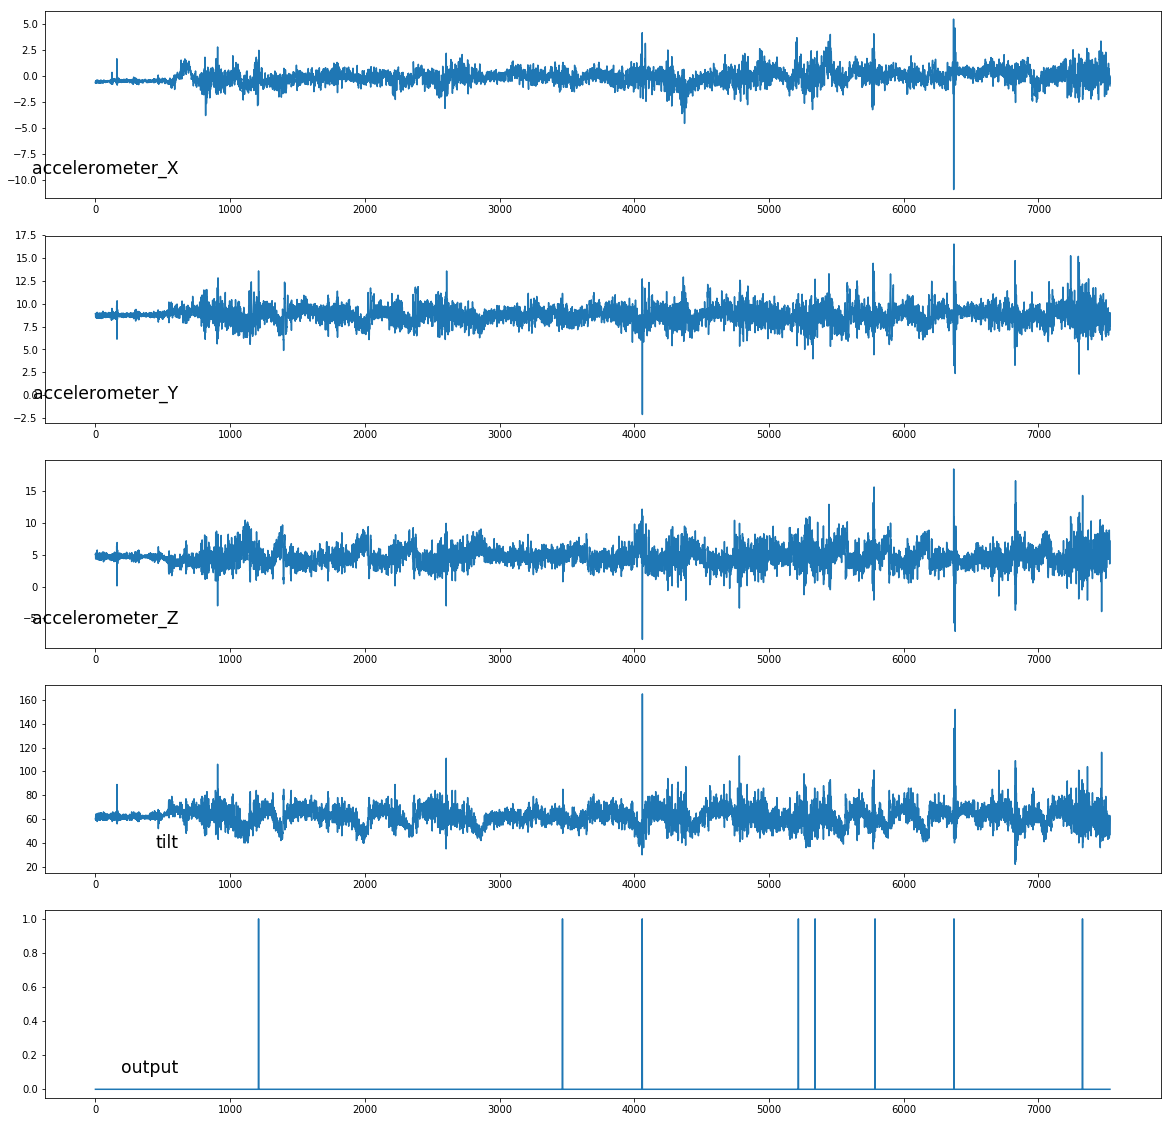

In [33]:
# Show the graphs of accelerometer values
values = df_general.values

# specify columns to plot
groups = [0, 1, 2, 5, 8]
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df_general.columns[group], x =0.12,y=0.1, size = 'xx-large', loc='right')
    i += 1
plt.show()

In [34]:
features = ['accelerometer_X','accelerometer_Y','accelerometer_Z','output']
values = df_general.filter(features, axis=1).values

# output column is removed to escape the normalization logic
no_output_values = values[:,:-1]

# ensure all data is float
no_output_values = no_output_values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(no_output_values)

# inserts output column back
scaled = np.insert(scaled, scaled.shape[1], values=values[:,-1], axis=1)

# specify the number of registers lag and n_features
# n_reg_lag = 60 means that i wanna process 60 values (2 seconds from past) from past to predict the current timestep
n_reg_lag  = 60
n_features = len(features)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_reg_lag, 1)

# drop columns we don't want to predict
reframed.drop(['var1(t)', 'var2(t)', 'var3(t)'], axis=1, inplace=True)

In [35]:
# split into train and test sets
values = reframed.values

n_obs = n_features * n_reg_lag

# Split data into training and test
_train, _test, out_train, out_test = train_test_split(values[:,:n_obs], values[:,[n_obs]], test_size=0.4, random_state=42)

print(_train.shape,out_train.shape, _test.shape, out_test.shape)

(4483, 240) (4483, 1) (2989, 240) (2989, 1)


In [36]:
# reshape input to be 3D [samples, timesteps, features]
_train = _train.reshape((_train.shape[0] , n_reg_lag, n_features))
_test  = _test.reshape ((_test.shape[0]  , n_reg_lag, n_features))

print(_train.shape, out_train.shape, _test.shape, out_test.shape)

(4483, 60, 4) (4483, 1) (2989, 60, 4) (2989, 1)


In [1]:
# ESTOU ESTUDANDO COMO UTILIZAR O CÓDIGO ABAIXO E SE VOU PRECISAR!

#from sklearn.preprocessing import LabelEncoder
#from keras.utils import np_utils

## encode class values as integers
#Y = list(df_general['output'])
#encoder = LabelEncoder()
#encoder.fit(Y)
#encoded_Y = encoder.transform(Y)
## convert integers to dummy variables (i.e. one hot encoded)
#dummy_y = np_utils.to_categorical(encoded_Y)

# Design Network

### Comentarios:
Terei que fazer algumas mudanças: 
A última layer do meu modelo tem de ser 3 pois a saída pode ser da classe 0 (default), 1 (buraco) ou 2 (quebra-mola).
Para isso, antes preciso realizar um LabelEncoder na minha saída. Ex: saída -> [ 0  0  1]  é evento de quebra mola

Train on 4483 samples, validate on 2989 samples
Epoch 1/80
 - 6s - loss: 0.0291 - acc: 0.9987 - val_loss: 0.0057 - val_acc: 0.9993
Epoch 2/80
 - 5s - loss: 0.0114 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 3/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 4/80
 - 5s - loss: 0.0114 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 5/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 6/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 7/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 8/80
 - 5s - loss: 0.0116 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 9/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0058 - val_acc: 0.9993
Epoch 10/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0059 - val_acc: 0.9993
Epoch 11/80
 - 5s - loss: 0.0115 - acc: 0.9987 - val_loss: 0.0059 - val_acc: 0.9993
Epoch 12/80
 - 5s - loss: 0.0115 - ac

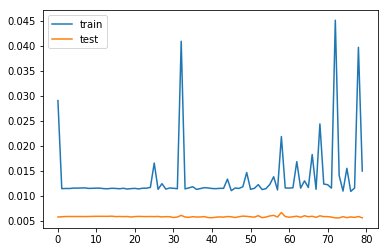

In [49]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(_train.shape[1], _train.shape[2])))
model.add(Dense(1))
#model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

#fit network
history = model.fit(_train, out_train, epochs=80, batch_size=40, validation_data=(_test, out_test), verbose=2, shuffle=False)

#plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


# Make a prediction

In [51]:
# make a prediction
yhat   = model.predict(_test)

# calculate RMSE
rmse = sqrt(mean_squared_error(out_test, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.026


# More generic plots

In [14]:
plotTooltipBokeh('accelerometer_Y', df_general, df_pothole,df_speedbump,'red',20,22)

Loading BokehJS ...

C:\Program Files\Anaconda3\lib\site-packages\bokeh\core\json_encoder.py:73: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  if pd and isinstance(obj, pd.tslib.Timestamp):


[]

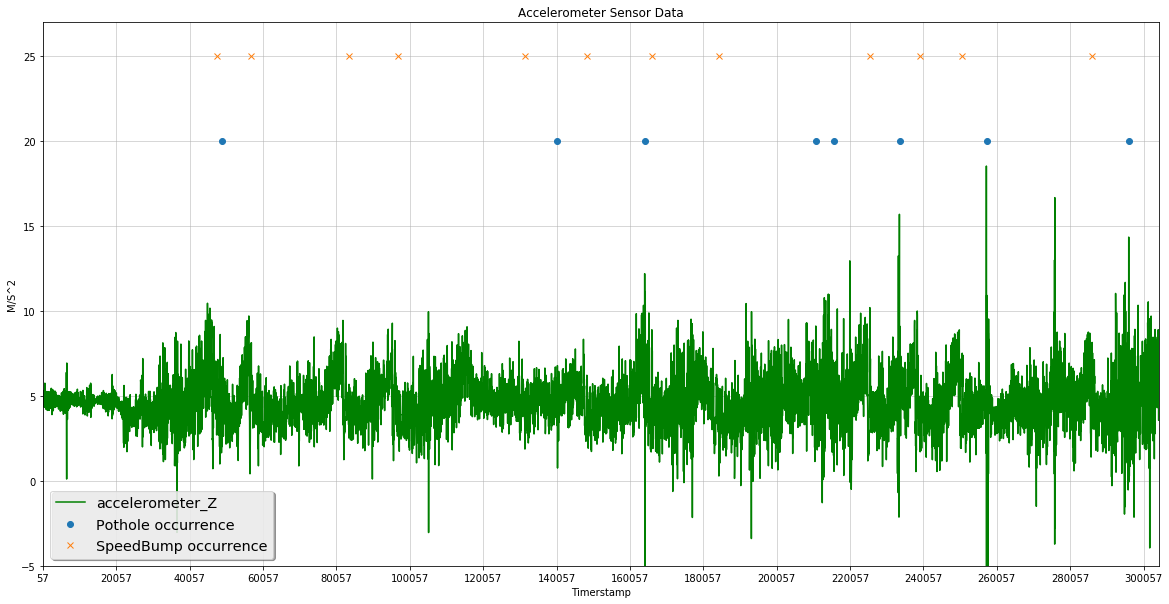

In [50]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(df_general['timestamp'],df_general['accelerometer_Z'], 'g-')

df_pothole['Pothole occurrence'] = 20
df_speedbump['SpeedBump occurrence'] = 25
ax.plot(df_pothole['timestamp'],df_pothole['Pothole occurrence'], 'o')
ax.plot(df_speedbump['timestamp'],df_speedbump['SpeedBump occurrence'], 'x')

#ax.legend(loc='lower left',bbox_to_anchor=(1.1, 0.5),fontsize='x-large')
ax.legend(loc='lower left',fontsize='x-large',shadow = bool)
ax.set_ylabel('M/S^2')
ax.set_xlabel('Timerstamp')
ax.set_title('Accelerometer Sensor Data')
ax.grid(True,linewidth=0.5,linestyle='-')
ax.set_xticks(np.arange(df_general['timestamp'].min(),df_general['timestamp'].max(), 20000))
ax.set_xlim([df_general['timestamp'].min(), df_general['timestamp'].max()])
ax.set_ylim([-5,27])
ax.plot()